# Lab 1: TensorFlow Tutorial and Some Useful Functions
Welcome to the first lab in this course. Here you will see and try out some basics of TensorFlow and get familiar with some of the useful functions that you will use across the assignments. If you already know TensorFlow well, feel free to skip this notebook.

For the demonstration purposes you will use the [IMDB reviews](https://ai.stanford.edu/~amaas/data/sentiment/) dataset, on which you will perform sentiment classification. The dataset consists of 50,000 movie reviews from the Internet Movie Database ([IMDB](https://www.imdb.com/)), but has been shrinked down to 6,000 reviews to save space and ensure faster performance of the notebook.

A part of the code in this notebook is reused from the TensorFlow [official tutorial](https://www.tensorflow.org/tutorials/keras/text_classification).

## Table of Contents
- [1 - Import the Libraries](#1)
- [2 - Load the Data](#2)
- [3 - Prepare the Data](#3)
- [4 - Create a Sequential Model](#4)
- [5 - Create a Model Using Functional API](#5)
- [6 - Train the Model](#6)
- [7 - Predict on Your Own Data](#7)


<a name="1"></a>
## 1. Import the libraries

In [1]:
# To silence the TensorFlow warnings, you can use the following code before you import the TensorFlow library.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt

print("Imports successful!")

Imports successful!


Setting the random seed allows you to have control over the (pseudo)random numbers. When you are working with neural networks this is a good idea, so you can get reproducible results (when you run the calculation twice you will always get the same "random" numbers). It is especially important not to mess with the random seed in your assignments, as they are used for checking whether your values are set correctly.

In [2]:
# Select your favourite number for the random seed
seed = 42

# Sets the global random seed for numpy.
np.random.seed(seed)
# Sets the global random seed for TensorFlow.
tf.random.set_seed(seed)

print(f"Random seed set to {seed}")

Random seed set to 42


<a name="2"></a>
## 2. Load the data
First you set the path to the directory where you store your data.

In [3]:
data_dir = './data/aclImdb'

Below, you will use the function [tf.keras.utils.text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory), that generates a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) from text files in a directory.
TensorFlow allows you for very easy dataset creation, provided that you have data in the following folder substructure.
```
main_directory/
... class_a/
...... a_text_1.txt
...... a_text_2.txt
... class_b/
...... b_text_1.txt
...... b_text_2.txt
```

Calling `text_dataset_from_directory(...)` will return a `tf.data.Dataset` that yields batches of texts from the subdirectories `class_a` and `class_b`, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

Only .txt files are supported at this time, but there are equivalent functions for different kinds of data, for example `image_dataset_from_directory` for images.

In your case you have two main directories: `./data/aclImdb/train/` and `./data/aclImdb/test/`. Within both of these two directories you have data separated in two classes: `neg` and `pos`. So your actual folder structure looks like this:

```
./data/aclImdb/train/
... neg/
...... text_1.txt
...... text_2.txt
...... ...
... pos/
...... text_1.txt
...... text_2.txt
...... ...
```
And the same for the test folder, with many .txt files in each subfolder.

You can explore the folders by clicking `File` and then `Open` in the menu above, or by clicking on the Jupyter symbol.

In the cell below, you will load the data. Note the different parameters that you can use when loading the data. For example: originally you only have the data split only to training and test sets, but you can very easily split the datasets further, by using just a few parameters.

In [4]:
# Here you have two main directories: one for train and one for test data.
# You load files from each to create training and test datasets.

# Create the training set. Use 80% of the data and keep the remaining 20% for the validation.
raw_training_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='training', 
    seed=seed
)

# Create the validation set. Use 20% of the data that was not used for training.
raw_validation_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

# Create the test set.
raw_test_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 2 classes.


Check that the labels 0 and 1 correctly correspond to the negative and positive examples respectively.

In [5]:
print(f"Label 0 corresponds to {raw_training_set.class_names[0]}")
print(f"Label 1 corresponds to {raw_training_set.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


If you want to look at a small subset of your dataset, you can use `.take()` method, by passing it the `count` parameter. The method returns a new dataset of the size at most `count`, where `count` is the number of batches. You can read more about `tf.data.Dataset` and the `take` method [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [6]:
# Take one batch from the dataset and print out the first three datapoints in the batch
for text_batch, label_batch in raw_training_set.take(1):
    for i in range(3):
        print(f"Review:\n {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}\n")

Review:
 b'This is a reunion, a team, and a great episode of Justice. From hesitation to resolution, Clark has made a important leap from a troubled teenager who was afraid of a controlled destiny, to a Superman who, like Green Arrow, sets aside his emotions to his few loved ones, ready to save the whole planet. This is not just a thrilling story about teamwork, loyalty, and friendship; this is also about deciding what\'s more important in life, a lesson for Clark. I do not want the series to end, but I hope the ensuing episodes will strictly stick to what Justice shows without any "rewind" pushes and put a good end here of Smallville---and a wonderful beginning of Superman.<br /><br />In this episode, however, we should have seen more contrast between Lex and the Team. Nine stars should give it enough credit.'
Label: 1

Review:
 b'"Hey Babu Riba" is a film about a young woman, Mariana (nicknamed "Esther" after a famous American movie star), and four young men, Glenn, Sacha, Kicha, and

<a name="3"></a>
## 3. Prepare the Data

Now that you have seen how the dataset looks like, you need to prepare it in the format that a neural network understands. For this, you will use the [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer.

This layer converts text to vectors that can then be fed to a neural network. A very useful feature is that you can pass it another function that performs custom standardization of text. This includes lowercasing the text, removing punctuation and/or HTML elements, web links or certain tags. This is very important, as every dataset requires different standardization, depending on its contents. After the standardization, the layer tokenizes the text (splits into words) and vectorizes it (converts from words to numbers) so that it can be fed to the neural network. The `output_sequence_length` is set to 250, which means that the layer will pad shorter sequences or truncate longer sequences, so they will al have the same length. This is done so that all the inout vectors are the same length and can be nicely put together into matrices.

In [7]:
# Set the maximum number of words
max_features = 10000

# Define the custom standardization function
def custom_standardization(input_data):
    # Convert all text to lowercase
    lowercase = tf.strings.lower(input_data)
    # Remove HTML tags
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    # Remove punctuation
    replaced = tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
    )
    return replaced

# Create a layer that you can use to convert text to vectors
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=250)

Next, you call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build a vocabulary (an index of strings to integers). If you want to access the vocabulary, you can call the `.get_vocabulary()` on the layer. 

In [8]:
# Build the vocabulary
train_text = raw_training_set.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Print out the vocabulary size
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

Vocabulary size: 10000


Now you can define the final function that you will use to vectorize the text and see what it looks like.

Note that you need to add the `.expand_dims()`. This adds another dimension to your data and is very commonly used when processing data to add an additional dimension to accomodate for the batches.

In [9]:
# Define the final function that you will use to vectorize the text.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Get one batch and select the first datapoint
text_batch, label_batch = next(iter(raw_training_set))
first_review, first_label = text_batch[0], label_batch[0]

# Show the raw data
print(f"Review:\n{first_review}")
print(f"\nLabel: {raw_training_set.class_names[first_label]}")
# Show the vectorized data
print(f"\nVectorized review\n{vectorize_text(first_review, first_label)}")

Review:
b"Okay, so the plot is on shaky ground. Yeah, all right, so there are some randomly inserted song and/or dance sequences (for example: Adam's concert and Henri's stage act). And Leslie Caron can't really, um, you know... act.<br /><br />But somehow, 'An American In Paris' manages to come through it all as a polished, first-rate musical--largely on the basis of Gene Kelly's incredible dancing talent and choreography, and the truckloads of charm he seems to be importing into each scene with Caron. (He needs to, because she seems to have a... problem with emoting.) <br /><br />The most accomplished and technically awe-inspiring number in this musical is obviously the 16-minute ballet towards the end of the film. It's stunningly filmed, and Kelly and Caron dance beautifully. But my favourite number would have to be Kelly's character singing 'I Got Rhythm' with a bunch of French school-children, then breaking into an array of American dances. It just goes to prove how you don't need

Now you can apply the vectorization function to vectorize all three datasets.

In [10]:
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

### Configure the Dataset

There are two important methods that you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

For very interested, you can read more about `tf.data` and `AUTOTUNE` in this [paper](https://vldb.org/pvldb/vol14/p2945-klimovic.pdf), but be aware that this is already very advanced information about how TensorFlow works.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<a name="4"></a>
## 4. Create a Sequential Model

A [Sequential model](https://www.tensorflow.org/guide/keras/sequential_model) is appropriate for a simple stack of layers where each layer has exactly one input tensor and one output tensor (layers follow each other in a sequence and there are no additional connections).

Here you will use a Sequential model using only three layers:
 - An [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
 - A [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
 - A [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with a single output node.

In [12]:
embedding_dim = 16

# Create the model by calling tf.keras.Sequential, where the layers are given in a list.
model_sequential = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

# Print out the summary of the model
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model. Choose the loss function, the optimizer and any additional metrics you want to calculate. Since this is a binary classification problem you can use the [losses.BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss function.

In [13]:
model_sequential.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

<a name="5"></a>
## 5. Create a Model Using Functional API

You can use the [functional API](https://www.tensorflow.org/guide/keras/functional_api) when you want to create more complex models, but it works just as well for the simple models like the one above. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The biggest difference at the first glance is that you need to explicitly state the input. Then you use the layers as functions and pass previous layers as parameters into the functions. In the end you build a model, where you pass it the input and the output of the neural network. All of the information from between them (hidden layers) is already hidden in the output layer (remember how each layer takes the previous layer in as a parameter).

In [14]:
# Define the inputs
inputs = tf.keras.Input(shape=(None,))

# Define the first layer
embedding = layers.Embedding(max_features, embedding_dim)
# Call the first layer with inputs as the parameter
x = embedding(inputs)

# Define the second layer
pooling = layers.GlobalAveragePooling1D()
# Call the first layer with the output of the previous layer as the parameter
x = pooling(x)

# Define and call in the same line. (Same thing used two lines of code above
# for other layers. You can use any option you prefer.)
outputs = layers.Dense(1, activation='sigmoid')(x)
#The two-line alternative to the one layer would be:
# dense = layers.Dense(1, activation='sigmoid')
# x = dense(x)


# Create the model
model_functional = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print out the summary of the model
model_functional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model: choose the loss, optimizer and any additional metrics you want to calculate. This is the same as for the sequential model.

In [15]:
model_functional.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

<a name="6"></a>
## 6. Train the Model

Above, you have defined two different models: one with a functional api and one sequential model. From now on, you will use only one of them. feel free to change which model you want to use in the next cell. The results should be the same, as the architectures of both models are the same.

In [16]:
# Select which model you want to use and train. the results should be the same
model = model_functional # model = model_sequential

Now you will train the model. You will pass it the training and validation dataset, so it can compute the accuracy metric on both during training.

In [17]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=2
)

Epoch 1/25
125/125 - 2s - loss: 0.6902 - accuracy: 0.5470 - val_loss: 0.6857 - val_accuracy: 0.7160 - 2s/epoch - 17ms/step
Epoch 2/25
125/125 - 1s - loss: 0.6778 - accuracy: 0.7305 - val_loss: 0.6714 - val_accuracy: 0.7330 - 743ms/epoch - 6ms/step
Epoch 3/25
125/125 - 1s - loss: 0.6572 - accuracy: 0.7520 - val_loss: 0.6496 - val_accuracy: 0.7400 - 802ms/epoch - 6ms/step
Epoch 4/25
125/125 - 1s - loss: 0.6288 - accuracy: 0.7775 - val_loss: 0.6225 - val_accuracy: 0.7730 - 833ms/epoch - 7ms/step
Epoch 5/25
125/125 - 1s - loss: 0.5956 - accuracy: 0.7952 - val_loss: 0.5935 - val_accuracy: 0.7880 - 755ms/epoch - 6ms/step
Epoch 6/25
125/125 - 1s - loss: 0.5604 - accuracy: 0.8142 - val_loss: 0.5651 - val_accuracy: 0.7990 - 761ms/epoch - 6ms/step
Epoch 7/25
125/125 - 1s - loss: 0.5254 - accuracy: 0.8350 - val_loss: 0.5384 - val_accuracy: 0.8000 - 781ms/epoch - 6ms/step
Epoch 8/25
125/125 - 1s - loss: 0.4916 - accuracy: 0.8537 - val_loss: 0.5137 - val_accuracy: 0.8070 - 717ms/epoch - 6ms/step
Ep

Now you can use `model.evaluate()` to evaluate the model on the test dataset.

In [18]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

157/157 [==============================] - 1s 6ms/step - loss: 0.3642 - accuracy: 0.8456
Loss: 0.36422795057296753
Accuracy: 0.8456000089645386


When you trained the model, you saved the history in the history variable. Here you can access a dictionary that contains everything that happened during the training. In your case it saves the losses and the accuracy on both training and validation sets. You can plot it to gain some insights into how the training is progressing.

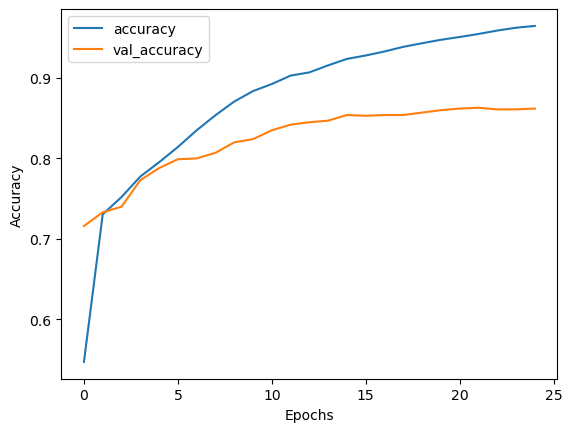

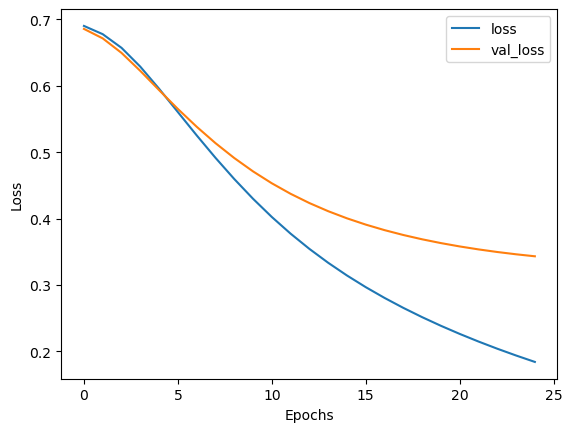

In [19]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

You can see that after 25 epochs, the training accuracy still goes up, but the validation accuracy already plateaus at around 86%. On the other hand both training and validation losses are still decreasing, which means that while the model does not learn to predict more cases accurately, it still gets more confident in its predictions. Here you used the simplest possible model: you have used embeddings, averaging layer and a dense layer with one output. You can try different architectures to see if the model improves. Perhaps you can add some dropout layers to reduce the chance of overfitting, or you can try a completely different architecture, like using convolutional layers or reccurent layers. You will learn a lot more about recurrent neural networks in the later weeks of this course.

<a name="7"></a>
## 7. Predict on Your Own Data

Finally, you can use the model to predict on any new data you may have. You can use it to predict the sentiment of examples in the test dataset (which the model has not seen in the training process) or use some completely new examples.

Here you will expand your model to be able to predict on raw strings (rather than on vectorized examples). Previously, you applied the TextVectorization layer to the dataset before feeding it to the model. To simplify deploying the model, you can include the TextVectorization layer inside your model and then predict on raw strings. To do so, you can create a new sequential model where you merge the vectorization layer with your trained model using the weights you just trained.

In [20]:
# Make a new sequential model using the vectorization layer and the model you just trained.
export_model = tf.keras.Sequential([
  vectorize_layer,
  model]
)

# Compile the model
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

Now you can use this model to predict on some of your own examples. You can do it simply by calling `model.predict()`

In [21]:
examples = ['this movie was very, very good', 'quite ok', 'the movie was not bad', 'bad', 'negative disappointed bad scary', 'this movie was stupid']

results = export_model.predict(examples, verbose=False)

for result, example in zip(results, examples):
    print(f'Result: {result[0]:.3f},   Label: {int(np.round(result[0]))},   Review: {example}')

Result: 0.624,   Label: 1,   Review: this movie was very, very good
Result: 0.540,   Label: 1,   Review: quite ok
Result: 0.425,   Label: 0,   Review: the movie was not bad
Result: 0.471,   Label: 0,   Review: bad
Result: 0.427,   Label: 0,   Review: negative disappointed bad scary
Result: 0.455,   Label: 0,   Review: this movie was stupid


Congratulations on finishing this lab. Do not worry if you did not understand everything, the videos and course material will cover these concepts in more depth. If you have a general understanding of the code in this lab, you are very well suited to start working on this weeks programming assignment. There you will implement some of the things shown in this lab from scratch and then create and fit a similar model like you did in this notebook.